Load packages

In [1]:
import cv2
import ipywidgets as widgets
import subprocess
import os
from ipyfilechooser import FileChooser
from IPython.display import display, Video, clear_output 
import holoviews as hv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

Choose video

In [2]:
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
    #dpath=dpath.parent
except:
    print("the path was not defined in store")
    dpath = "//10.69.168.1/crnldata/forgetting/"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Go inside the folder containing the LFP raw file</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\Analysed2025_AB\L1NDNF_mice\GreenLines', …

In [6]:
# Load the first video
video_path = sorted(glob.glob(os.path.join(dpath, "*.avi")))[0]

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

# Initialize accumulator
avg_frame = np.zeros((height, width, 3), np.float32)

# Read and accumulate frames
count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    avg_frame += frame.astype(np.float32)
    count += 1

cap.release()

# Compute the average frame
avg_frame /= count
avg_frame = avg_frame.astype(np.uint8)


Adjust brightness and contrast

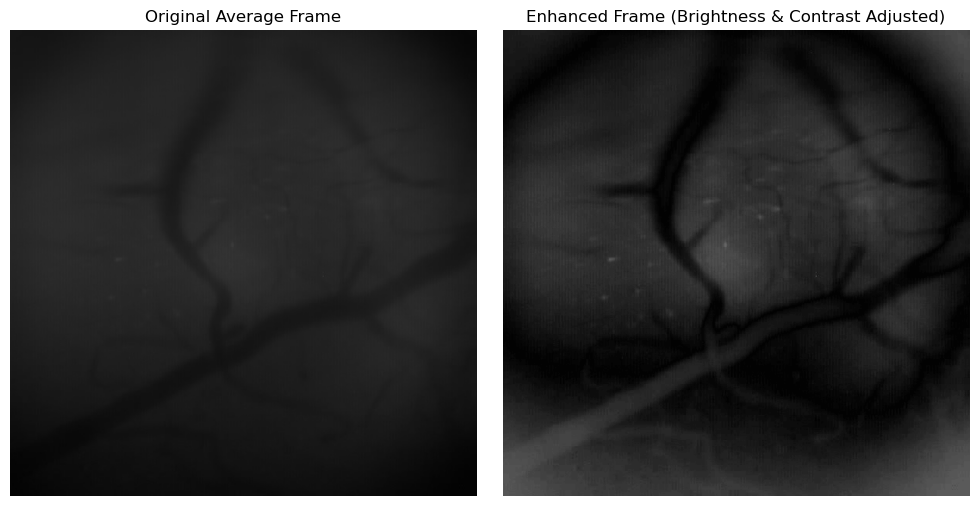

In [7]:
# Increase contrast and brightness
alpha = 3.5 # Contrast control (>1 increases contrast)
beta = -100   # Brightness control (>0 increases brightness)
enhanced_frame = cv2.convertScaleAbs(avg_frame, alpha=alpha, beta=beta)

# Convert BGR to RGB for Matplotlib
avg_frame_rgb = cv2.cvtColor(avg_frame, cv2.COLOR_BGR2RGB)
enhanced_frame_rgb = cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(avg_frame_rgb)
axes[0].set_title("Original Average Frame")
axes[0].axis("off")
axes[1].imshow(enhanced_frame_rgb)
axes[1].set_title("Enhanced Frame (Brightness & Contrast Adjusted)")
axes[1].axis("off")
plt.tight_layout()
plt.show()


Display video until the end

In [8]:
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties 
fps = 30 #cap.get(cv2.CAP_PROP_FPS)
speed= 10 # 5 times more rapid

frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

processed_frames=[]

# Play video frame by frame with modifications
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if the video ends

    # Get the current frame number
    frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    # Calculate the time in seconds
    time_sec = frame_number / fps

    # Apply contrast and brightness adjustment
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)

    # Define the position for the text (fixed position for frame number and time)
    time_position = (10, frame_height - 10)    # Position for time in seconds
    fixed_text_position= (380, frame_height - 10)    # Position for time in seconds

    # Display the time in seconds
    cv2.putText(enhanced_frame, f'{time_sec:.1f} s', time_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(enhanced_frame, f'Speed : x {speed}', fixed_text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
    
    # Show the enhanced video
    cv2.imshow("Enhanced Video (Contrast & Brightness Adjusted)", enhanced_frame)

    processed_frames.append(enhanced_frame)

    # Press 'q' to exit the video
    if cv2.waitKey(round(1/fps*1000/speed)) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Save the processed video

In [ ]:
output_path = "output_video.mp4"  # Define the output file path

# Create a VideoWriter object to save the processed video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec
out = cv2.VideoWriter(output_path, fourcc, fps*speed, (frame_width, frame_height))

# Save all the processed frames into the output video file
for frame in processed_frames:
    out.write(frame)

# Release the VideoWriter
out.release()
cv2.destroyAllWindows()

Save a merged video from all .avi files of the folder

In [9]:
fps = 30 # cap.get(cv2.CAP_PROP_FPS) 
speed = 3 # times more rapid

# Get all .avi files and sort them numerically
avi_files = sorted(glob.glob(os.path.join(dpath, "*.avi")), key=lambda x: int(os.path.basename(x).split(".")[0]))

# Check if there are any .avi files
if not avi_files:
    print("No .avi files found in the folder.")
    exit()

# Read the first video to get properties
first_video = cv2.VideoCapture(avi_files[0])
frame_width = int(first_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(first_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(first_video.get(cv2.CAP_PROP_FPS))
first_video.release()

# Define the output file
#output_file = os.path.join(dpath, "merged.avi")
#fourcc = cv2.VideoWriter_fourcc(*"XVID")  # Codec for AVI format
#out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))
output_file = os.path.join(dpath, "merged.mp4")
fourcc = cv2.VideoWriter_fourcc(*'H264')  # H264 or MP4 codec
out = cv2.VideoWriter(output_file, fourcc, fps*speed, (frame_width, frame_height))

f = 1
tot_time = 0

# Process each .avi file
for file in avi_files:
    cap = cv2.VideoCapture(file)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Calculate the time in seconds
        tot_time = f / fps

        # Define the position for the text (fixed position for frame number and time)
        time_position = (10, frame_height - 10)    # Position for time in seconds
        frame_position = (10, 30)    # Position for frame in seconds
        fixed_text_position= (380, frame_height - 10)    # Position for time in seconds

        # Adjust contrast and brightness
        adjusted_frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)
        # Flip the frame horizontally
        flipped_frame = cv2.flip(adjusted_frame, 1)

        # Display the time in seconds
        cv2.putText(adjusted_frame, f'{tot_time:.1f} s', time_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(adjusted_frame, f'Speed : x {speed}', fixed_text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(adjusted_frame, f'Frame #{f}', frame_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
        
        # Write the modified frame
        out.write(adjusted_frame)
        f += 1

    cap.release()

# Release the output video writer
out.release()
print(f"Merged video saved as {output_file}")

Merged video saved as \\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\RAW\Baseline_recording\GreenLines\Baseline_recording\2022_08_04\13_14_05\My_V4_Miniscope\merged.mp4
